# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0

https://drive.google.com/file/d/1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr/view?usp=sharing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())
"""
id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr': 'test_y_label.npz'       }
"""
id_to_fn = {
'1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
'1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
'1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz' }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Mounted at /content/drive


In [2]:
import numpy as np
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn

# Data Preprocessing

Here you will implement a pytorch data processor that loads tha images and computes the ground truth labels as described in the PDF.


In [3]:
def create_y_label(image, raw_label):

  #Assume x to be the downwward vertical direction and y is right horizontal
  
  y_label = np.zeros((8,8,8))

  image_width  = 128            #image.shape[1] 
                                # Direction : ---->>
                                # Image width is in the right horizontal direction
                                # which is the direction of y in image 
  
  image_height = 128            #image.shape[0] 
                                # Direction : ||||vvvv
                                # Image height is in the down vertical direction
                                # which is the direction of x in image

  grid_size_x = image_height/8
  grid_size_y = image_width/8
  

  #1. Compute the grid cell index
  center_x = (raw_label[:,1] + raw_label[:,3])/2
  center_y = (raw_label[:,2] + raw_label[:,4])/2
  
  grid_index_x = np.floor(center_x/grid_size_x).astype(int)
  grid_index_y = np.floor(center_y/grid_size_x).astype(int)

  y_label[0,grid_index_x, grid_index_y] = 1

  #2. Compute x and y
  x = (center_x%grid_size_x)/grid_size_x
  y = (center_y%grid_size_x)/grid_size_y

  y_label[1,grid_index_x,grid_index_y] = x
  y_label[2,grid_index_x,grid_index_y] = y

  #3. w and h, w is in vertical direction i.e. in the direction of x
  
  w = (raw_label[:,3] - raw_label[:,1])/image_height
  h = (raw_label[:,4] - raw_label[:,2])/image_width

  y_label[3,grid_index_x,grid_index_y] = w
  y_label[4,grid_index_x,grid_index_y] = h

  #4. Class Probabilities
  labels = (raw_label[:,0] + 5).astype(int)
  y_label[labels,grid_index_x,grid_index_y] = 1
  

  return y_label

#Set up the data set for training and testing.

In [4]:
class splitDataset(Dataset):
  def __init__(self,images, labels, data_transforms = None):

    self.images = images
    self.labels = labels
  
  def __len__(self):
    return self.images.shape[0]
  
  def __getitem__(self,idx):
    return self.images[idx,:,:,:],self.labels[idx]

def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  images = np.load(image_path,allow_pickle=True)['arr_0']
  labels = np.load(labels_path,allow_pickle=True, encoding = 'latin1')['arr_0']

  dataset = splitDataset(images = images, labels = labels)
  
  length_dataset = len(dataset)
  train_length = int(0.8*length_dataset)
  test_length = length_dataset - train_length

  train,test = random_split(dataset,[train_length,test_length])

  train_images = train[:][0]
  train_raw_labels = train[:][1]
  test_images = test[:][0]
  test_raw_labels = test[:][1]

  return train_images, train_raw_labels, test_images, test_raw_labels

In [5]:
class YOLODataset(Dataset):
  def __init__(self,images, labels, data_transforms = None):

    self.images = images
    self.images = self.images.transpose(0,3,1,2)
    self.labels = labels
  
  def __len__(self):
    return self.images.shape[0]
  
  def __getitem__(self,idx):
    return self.images[idx,:,:,:],self.labels[idx]

In [6]:
## use the processed labels and use the correct image dimensions for the pytorch loader.
## images = images.transpose(0,3,1,2)

BATCH_SIZE = 64
train_images, train_raw_labels, test_images, test_raw_labels = loadData("images.npz", "labels.npz")

train_y_labels = np.zeros((len(train_images),8,8,8))
for i in range(len(train_images)):
  train_y_labels[i,:,:,:] = create_y_label(train_images[i], train_raw_labels[i])

test_y_labels = np.zeros((len(test_images),8,8,8))
for i in range(len(test_images)):
  test_y_labels[i,:,:,:] = create_y_label(test_images[i], test_raw_labels[i])


train_dataset = YOLODataset(images = train_images, labels = train_y_labels)
test_dataset = YOLODataset(images = test_images, labels = test_y_labels)

trainloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

# Model Definition

In [7]:
class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO,self).__init__()
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()

    self.conv1 = nn.Conv2d(3,32,4, stride = 2, padding = 1)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32,64,4, stride = 2, padding = 1)
    self.bn2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(64,128,4, stride = 2, padding = 1)
    self.bn3 = nn.BatchNorm2d(128)

    self.conv4 = nn.Conv2d(128,256,4, stride = 2, padding = 1)
    self.bn4 = nn.BatchNorm2d(256)

    self.conv5 = nn.Conv2d(256,512,4, stride = 2, padding = 1)
    self.bn5 = nn.BatchNorm2d(512)

    self.conv6 = nn.Conv2d(512,1024,4, stride = 2, padding = 1)
    self.bn6 = nn.BatchNorm2d(1024)

    self.conv7 = nn.ConvTranspose2d(1024,256,4, stride = 2, padding = 1)
    self.bn7 = nn.BatchNorm2d(256)

    self.conv8 = nn.ConvTranspose2d(256,64,4, stride = 2, padding = 1)
    self.bn8 = nn.BatchNorm2d(64)

    self.conv9 = nn.Conv2d(64,8,3, stride = 1, padding = 1)

  def forward(self, X):
    X = self.relu(self.bn1(self.conv1(X)))
    X = self.relu(self.bn2(self.conv2(X)))
    X = self.relu(self.bn3(self.conv3(X)))
    X = self.relu(self.bn4(self.conv4(X)))
    X = self.relu(self.bn5(self.conv5(X)))
    X = self.relu(self.bn6(self.conv6(X)))
    X = self.relu(self.bn7(self.conv7(X)))
    X = self.relu(self.bn8(self.conv8(X)))
    #X = self.relu(self.conv9(X))
    X = self.sig(self.conv9(X))
    #X = torch.exp(self.conv9(X))

    return X


# Training you network

I have defined IoU and Loss function here. NMS and Average precision function are defined in the end. I save the model at every epoch of training and calculate average precision in the end by loading model at every epoch

In [8]:
def IOU(bbox_1 ,bbox_2):
  '''
  bbox_1 = N x 4 (x1,y1,x2,y2)
  bbox_2 = N x 4 (x1,y1,x2,y2)

  (x1,y1) are coordinates of top left corner of box
  (x2,y2) are coordinates of bottom corner of box
  '''
  N = bbox_1.shape[0]
  zeros = torch.zeros(N).to(device)
  interA_x = torch.max(bbox_1[:,0],bbox_2[:,0])
  interA_y = torch.max(bbox_1[:,1],bbox_2[:,1])
  interB_x = torch.min(bbox_1[:,2],bbox_2[:,2])
  interB_y = torch.min(bbox_1[:,3],bbox_2[:,3])

  inter_area = torch.max(zeros,interB_x - interA_x + 1) * torch.max(zeros,interB_y - interA_y + 1)

  bbox1_area = (bbox_1[:,2] - bbox_1[:,0] + 1) * (bbox_1[:,3] - bbox_1[:,1] + 1)
  bbox2_area = (bbox_2[:,2] - bbox_2[:,0] + 1) * (bbox_2[:,3] - bbox_2[:,1] + 1)

  iou = inter_area/(bbox1_area + bbox2_area - inter_area)
  return iou
  
def calc_confidence_score(prediction, grnd_truth):
  C_error = 0
  x_mesh, y_mesh = torch.meshgrid(torch.arange(8),torch.arange(8))
  x_mesh = x_mesh.to(device).float()
  y_mesh = y_mesh.to(device).float()
  for batch in range(grnd_truth.shape[0]):
    pred_x = prediction[batch,1,:,:]*16 + 16*y_mesh
    pred_y = prediction[batch,2,:,:]*16 + 16*x_mesh
    pred_w = prediction[batch,3,:,:]*64
    pred_h = prediction[batch,4,:,:]*64

    truth_x = grnd_truth[batch,1,:,:]*16 + 16*y_mesh
    truth_y = grnd_truth[batch,2,:,:]*16 + 16*x_mesh
    truth_w = grnd_truth[batch,3,:,:]*64
    truth_h = grnd_truth[batch,4,:,:]*64

    mask = grnd_truth[batch,0,:,:] == 1
    pred_top_x    = (pred_x - pred_w)[mask]
    pred_top_y    = (pred_y - pred_h)[mask]
    pred_bottom_x = (pred_x + pred_w)[mask]
    pred_bottom_y = (pred_y + pred_h)[mask]

    truth_top_x    = (truth_x - truth_w)[mask]
    truth_top_y    = (truth_y - truth_h)[mask]
    truth_bottom_x = (truth_x + truth_w)[mask]
    truth_bottom_y = (truth_y + truth_h)[mask]

    bbox1 = torch.stack([pred_top_x  , pred_top_y  , pred_bottom_x  , pred_bottom_y] ,dim = 1)
    bbox2 = torch.stack([truth_top_x , truth_top_y , truth_bottom_x , truth_bottom_y],dim = 1)

    iou = IOU(bbox1,bbox2)
    error = ((prediction[batch,0,:,:][mask] - iou)**2).sum()
    C_error += error
  return C_error

In [9]:
def YoloLoss(output,truth,lambda_coord,lambda_noobj):
  #Classification Loss
  cl_loss = torch.sum( (truth[:,0,:,:]*( (truth[:,5,:,:] - output[:,5,:,:]) **2 )) + \
            (truth[:,0,:,:]*( (truth[:,6,:,:] - output[:,6,:,:]) **2 )) + \
            (truth[:,0,:,:]*( (truth[:,7,:,:] - output[:,7,:,:]) **2 )) )

  #Localization Loss
  local_loss = lambda_coord*torch.sum(
                truth[:,0,:,:] * ( 
                    (truth[:,1,:,:] - output[:,1,:,:])**2 + \
                    (truth[:,2,:,:] - output[:,2,:,:])**2 + \
                    ((truth[:,3,:,:]**0.5) - (output[:,3,:,:]**0.5))**2 + \
                    ((truth[:,4,:,:]**0.5) - (output[:,4,:,:]**0.5))**2
                )
              )
  #Confidence Loss
  C_error = calc_confidence_score(output,truth)
  #C_error = torch.sum( truth[:,0,:,:]*((truth[:,0,:,:] - output[:,0,:,:])**2) )

  C_error_0 = lambda_noobj*torch.sum(
                                    (1 - truth[:,0,:,:])*((truth[:,0,:,:] - output[:,0,:,:])**2)
                                    )

  return [cl_loss + local_loss + C_error + C_error_0 , C_error, C_error_0]

**Train your network **

We suggest that you save checkpoints sand reload from the most recent. This is due time constraints within Colab


In [ ]:
resume = False # set this True if you want to resume training from a checkpoint

lambda_coord= 5
lambda_noobj =0.5

yolo_net=YOLO()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
yolo_net=yolo_net.to(device)

learning_rate = 1e-3

num_epochs = 70## intialize this, atleast 20 epoch required for training
loss_list = []
C_error_list = []
C_error_0_list = []

## intialize optimizer
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)

start_epoch = 0
if resume == True:
  path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 2: YOLO/Reproduce results for IOU,sigmoid,lr = 1e-3/yolo_epoch60'
  if ~torch.cuda.is_available():
    checkpoint = torch.load(path,map_location=torch.device("cpu"))
  else :
    checkpoint = torch.load(path)
  
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss_list = checkpoint['loss_list']
  C_error_list = checkpoint['C_error_list']
  C_error_0_list = checkpoint['C_error_0_list']
  
for epochs in range(start_epoch+1,num_epochs+1):
    path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 2: YOLO/Reproduce results for IOU,sigmoid,lr = 1e-3/'
    yolo_net.train()
    for idx, data in enumerate(trainloader):
      print("Epoch %d/%d" % (epochs, num_epochs) + " Iteration = " + str(idx))
      images, target = data
      images = images.to(device).float()
      target = target.to(device).float()
      optimizer.zero_grad()
      output = yolo_net(images)
      [loss, C_error, C_error_0] = YoloLoss(output, target, lambda_coord, lambda_noobj)
      if torch.isnan(loss):
        raise NameError('Got Nan')
      loss_list.append(loss)
      C_error_list.append(C_error)
      C_error_0_list.append(C_error_0)
      loss.backward()
      print(loss)
      optimizer.step()


    path = os.path.join(path,'yolo_epoch'+str(epochs))
    torch.save({
            'epoch': epochs,
            'loss_list': loss_list,
            'C_error_list': C_error_list,
            'C_error_0_list': C_error_0_list,
            'model_state_dict': yolo_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)

# Visualize Losses

In [11]:
path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 2: YOLO/Fresh start np.sigmoid, Learning rate = 1e-4 Confidence loss plot, Only 1 target for confidence/yolo_epoch30'

yolo_net=YOLO()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
yolo_net=yolo_net.to(device)

if ~torch.cuda.is_available():
  checkpoint = torch.load(path,map_location=torch.device("cpu"))
else :
  checkpoint = torch.load(path)

yolo_net.load_state_dict(checkpoint['model_state_dict'])
optimizer=torch.optim.Adam(yolo_net.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
C_error_list = checkpoint['C_error_list']
C_error_0_list = checkpoint['C_error_0_list']

yolo_net.eval()

YOLO(
  (relu): ReLU()
  (sig): Sigmoid()
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(1024, eps=1e-05, mom

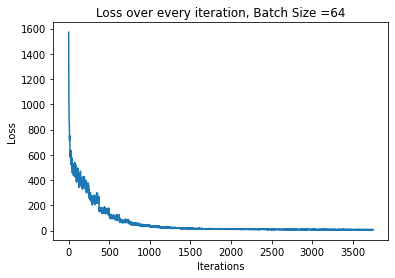

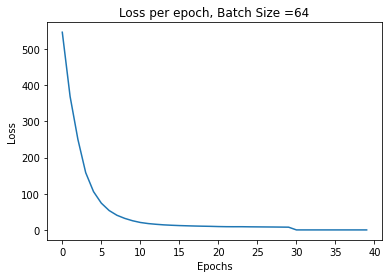

In [13]:
#Plot Loss
plt.plot(loss_list)
plt.title('Loss over every iteration, Batch Size =64')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("7.4 loss_every_iteration.png")

#Plot loss for first 40 epochs
loss_40_epochs = loss_list[0:5000]
loss_per_epoch = []
"""
for i in range(5000):
  if (i+1)%125 == 0
"""
loss_list_per_epoch = [loss_40_epochs[i:i+125] for i in range(0,5000,125)]
loss_per_epoch = [sum(loss_list_per_epoch[i])/125 for i in range(40)]
plt.figure()
plt.plot(loss_per_epoch)
plt.title('Loss per epoch, Batch Size =64')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("7.4 loss_per_epoch.png")

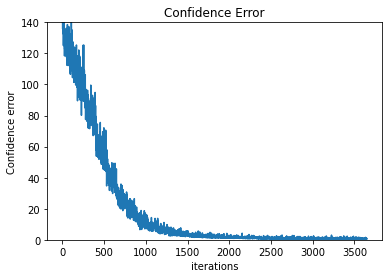

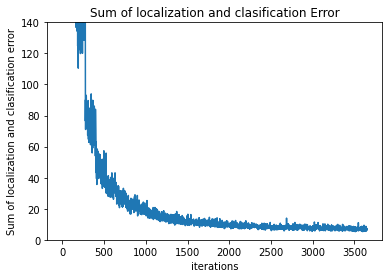

In [14]:
plt.figure(1)
plt.ylim([0,140])
plt.plot(np.array(C_error_list[100:]) + np.array(C_error_0_list[100:]))
plt.xlabel("iterations")
plt.ylabel("Confidence error")
plt.title("Confidence Error")
plt.savefig("Confidence Error.png")

plt.figure(2)
plt.ylim([0,140])
plt.plot(np.array(loss_list[100:]) - np.array(C_error_list[100:]) - np.array(C_error_0_list[100:]))
plt.xlabel("iterations")
plt.ylabel("Sum of localization and clasification error")
plt.title("Sum of localization and clasification Error")
plt.savefig("Localization + classification.png")

# Test your network.
Use the test images you created in the data preprocessing step. 


In [15]:
# images = np.load('images.npz',allow_pickle=True)['arr_0']
# raw_labels = np.load('labels.npz',allow_pickle=True, encoding = 'latin1')['arr_0']
images = test_images
raw_labels = test_raw_labels

# images = train_images
# raw_labels = train_raw_labels

In [16]:
path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 2: YOLO/Fresh start np.sigmoid, Learning rate = 1e-4 Confidence loss plot, Only 1 target for confidence/yolo_epoch30'

yolo_net=YOLO()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
yolo_net=yolo_net.to(device)

if ~torch.cuda.is_available():
  checkpoint = torch.load(path,map_location=torch.device("cpu"))
else :
  checkpoint = torch.load(path)

yolo_net.load_state_dict(checkpoint['model_state_dict'])
optimizer=torch.optim.Adam(yolo_net.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
C_error_list = checkpoint['C_error_list']
C_error_0_list = checkpoint['C_error_0_list']

yolo_net.eval()

YOLO(
  (relu): ReLU()
  (sig): Sigmoid()
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(1024, eps=1e-05, mom

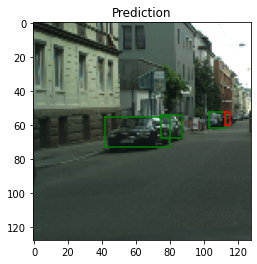

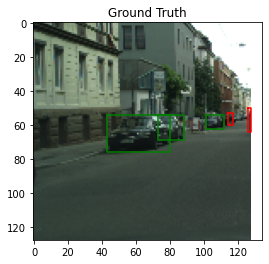

In [18]:
index = 6
image = images[index]
image = image[np.newaxis]
image = image.transpose(0,3,1,2)
image = torch.tensor(image).to(device).float()

processed_label = yolo_net(image)[0].cpu().detach().numpy()
true_label = raw_labels[index]

threshold = 0.6

#Plot 

plt.figure(1)
plt.imshow(images[index])
plt.title("Prediction")
# Convert the 8x8x8 back to original image
object_detected = (processed_label[0,:,:] > threshold)# == 1)
grid_idx =  np.where(object_detected)

object_array = processed_label[:,grid_idx[0],grid_idx[1]]
object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

half_width = object_array[3]*128 / 2
half_height = object_array[4]*128 / 2

for i in range(object_array.shape[1]):
  x = object_x[i]
  y = object_y[i]

  w = half_width[i]
  h = half_height[i]

  x_coordinates = [x - w , x - w, x + w,
                 x + w, x - w]
  y_coordinates = [y - h, y + h, y + h,
                 y - h, y - h]

  if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green) 
    plt.plot(x_coordinates,y_coordinates,'r-')
  elif (np.argmax(object_array[5:8,i]) == 1):
    plt.plot(x_coordinates,y_coordinates,'b-')
  elif (np.argmax(object_array[5:8,i]) == 2):
    plt.plot(x_coordinates,y_coordinates,'g-')
plt.savefig("7.7.png")

#Ground Truth
plt.figure(3)
plt.imshow(images[index])
plt.title("Ground Truth")
for i in range(true_label.shape[0]):
  x1 = true_label[i,1]
  y1 = true_label[i,2]
  x2 = true_label[i,3]
  y2 = true_label[i,4]
  x_coordinates = [x1,x1,x2,x2,x1]
  y_coordinates = [y1,y2,y2,y1,y1]
  if (true_label[i,0] == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green) 
    plt.plot(x_coordinates,y_coordinates,'r-')
  if (true_label[i,0] == 1):
    plt.plot(x_coordinates,y_coordinates,'b-')
  if (true_label[i,0] == 2):
    plt.plot(x_coordinates,y_coordinates,'g-')
plt.savefig("ground truth.png")

#Non-Max Suppression


In [19]:
np.set_printoptions(precision=2)
import copy

In [20]:
def IoU_NMS(c_mat_1, c_mat_2):
  """
  Input: N x 4 ---> (x_center,y_center,w,h)
  """
  top_x_1 = (c_mat_1[:,0] - c_mat_1[:,2]).reshape(-1,1)
  top_y_1 = (c_mat_1[:,1] - c_mat_1[:,3]).reshape(-1,1)
  bottom_x_1 = (c_mat_1[:,0] + c_mat_1[:,2]).reshape(-1,1)
  bottom_y_1 = (c_mat_1[:,1] + c_mat_1[:,3]).reshape(-1,1)
  area_box_1 = (c_mat_1[:,2]*c_mat_1[:,3]*4).reshape(-1,1)  # x4 because i divided by 64 rather than 128

  top_x_2 = (c_mat_2[:,0] - c_mat_2[:,2]).reshape(-1,1)
  top_y_2 = (c_mat_2[:,1] - c_mat_2[:,3]).reshape(-1,1)
  bottom_x_2 = (c_mat_2[:,0] + c_mat_2[:,2]).reshape(-1,1)
  bottom_y_2 = (c_mat_2[:,1] + c_mat_2[:,3]).reshape(-1,1)
  area_box_2 = (c_mat_2[:,2]*c_mat_2[:,3]*4).reshape(-1,1)

  inter_top_x =    np.maximum(top_x_1,top_x_2.T) #1st row shows the intersection of first box with all other boxes
  inter_top_y =    np.maximum(top_y_1,top_y_2.T)
  inter_bottom_x = np.minimum(bottom_x_1,bottom_x_2.T)
  inter_bottom_y = np.minimum(bottom_y_1,bottom_y_2.T)

  """
  For inter_area and union_area below:
  ith row shows the area of ith object with all other objects
  """
  inter_area = np.maximum(0, inter_bottom_x - inter_top_x) * np.maximum(0, inter_bottom_y - inter_top_y) 
  union_area = area_box_1 + area_box_2.T - inter_area
  iou = inter_area/(union_area)
  return iou

def NMS(prediction,confidence_threshold, area_threshold):
  low_confidence_idx = np.where(prediction[0,:,:] < confidence_threshold)
  prediction[0,low_confidence_idx[0],low_confidence_idx[1]] = 0 
  
  object_idx = np.where(prediction[0,:,:]>0)
  pred_clone = copy.deepcopy(prediction)
  
  x_mesh, y_mesh = np.meshgrid(torch.arange(8),torch.arange(8))
  pred_clone[1,:,:] = pred_clone[1,:,:]*16 + 16*y_mesh
  pred_clone[2,:,:] = pred_clone[2,:,:]*16 + 16*x_mesh
  pred_clone[3,:,:] = pred_clone[3,:,:]*64
  pred_clone[4,:,:] = pred_clone[4,:,:]*64

  if np.sum(pred_clone[0,:,:] >confidence_threshold) == 0:
    return prediction
  # objects = pred_clone[:,mask]     
  objects = pred_clone[:,object_idx[0],object_idx[1]] #Shape: 8 x N where N is number of objects detected

  predicted_class = np.argmax(objects[5:8,:],axis = 0)      #shape: (N,)
  # predicted_class_prob = np.amax(objects[5:8,:], axis = 0)  #shape: (N,)

  class_0_index = np.where(predicted_class == 0)    #Tuple object having array of shape: (no. of class 0 objects,)
  class_1_index = np.where(predicted_class == 1)    #Tuple object having array of shape: (no. of class 1 objects,)
  class_2_index = np.where(predicted_class == 2)    #Tuple object having array of shape: (no. of class 2 objects,)


  if (len(class_2_index[0]) !=0) and (len(class_2_index[0]) > 1) :
    class_2_array = objects[:,class_2_index[0]]
    # area_matrix = IoU_NMS(class_2_array[1:5,:].T)
    area_matrix = IoU_NMS(class_2_array[1:5,:].T, class_2_array[1:5,:].T)
    # print(area_matrix)
    mask = area_matrix > area_threshold
    
    prob_matrix = mask*class_2_array[0,:]

    # print(prob_matrix)
    for i in range(prob_matrix.shape[0]):
      if np.where(prob_matrix[i,i+1:] != 0)[0].shape[0] == 0:
        continue
      prob_row = prob_matrix[i,:]
      max_idx = np.argmax(prob_row)
      comparison = (np.where((prob_row[max_idx] > prob_row) & (prob_row != 0))[0]).tolist()
      class_2_array[0,comparison] = 0
      #class_2_array[0,max_idx] = 1
    objects[:,class_2_index[0]] = class_2_array

  if (len(class_1_index[0]) !=0) and (len(class_1_index[0]) > 1) :
    class_1_array = objects[:,class_1_index[0]]
    
    # area_matrix = IoU_NMS(class_1_array[1:5,:].T)
    area_matrix = IoU_NMS(class_1_array[1:5,:].T,class_1_array[1:5,:].T)
    mask = area_matrix > area_threshold
    
    prob_matrix = mask*class_1_array[0,:]

    for i in range(prob_matrix.shape[0]):
      if np.where(prob_matrix[i,i+1:] != 0)[0].shape[0] == 0:
        continue
      prob_row = prob_matrix[i,:]
      max_idx = np.argmax(prob_row)
      comparison = (np.where((prob_row[max_idx] > prob_row) & (prob_row != 0))[0]).tolist()
      class_1_array[0,comparison] = 0
      #class_1_array[0,max_idx] = 1
    objects[:,class_1_index[0]] = class_1_array

  if (len(class_0_index[0]) !=0) and (len(class_0_index[0]) > 1) :
    class_0_array = objects[:,class_0_index[0]]
    
    # area_matrix = IoU_NMS(class_0_array[1:5,:].T)
    area_matrix = IoU_NMS(class_0_array[1:5,:].T,class_0_array[1:5,:].T)
    mask = area_matrix > area_threshold
    
    prob_matrix = mask*class_0_array[0,:]

    for i in range(prob_matrix.shape[0]):
      if np.where(prob_matrix[i,i+1:] != 0)[0].shape[0] == 0:
        continue
      prob_row = prob_matrix[i,:]
      max_idx = np.argmax(prob_row)
      comparison = (np.where((prob_row[max_idx] > prob_row) & (prob_row != 0))[0]).tolist()
      class_0_array[0,comparison] = 0
      #class_0_array[0,max_idx] = 1
    objects[:,class_0_index[0]] = class_0_array

  prediction[0,object_idx[0],object_idx[1]] = objects[0,:]

  return prediction

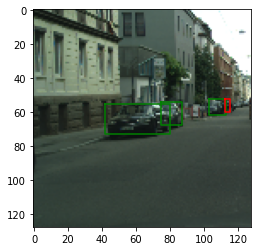

In [21]:
confidence_threshold = 0.6
area_threshold = 0.5
processed_label = NMS(processed_label, confidence_threshold, area_threshold)

plt.figure(1)
plt.imshow(images[index])

# Convert the 8x8x8 back to original image
object_detected = (processed_label[0,:,:] > threshold)# == 1)
grid_idx =  np.where(object_detected)

object_array = processed_label[:,grid_idx[0],grid_idx[1]]
object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

half_width = object_array[3]*128 / 2
half_height = object_array[4]*128 / 2

for i in range(object_array.shape[1]):
  x = object_x[i]
  y = object_y[i]

  w = half_width[i]
  h = half_height[i]

  x_coordinates = [x - w , x - w, x + w,
                 x + w, x - w]
  y_coordinates = [y - h, y + h, y + h,
                 y - h, y - h]
  #plt.plot(x_coordinates,y_coordinates,'r-')
  if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green) 
    plt.plot(x_coordinates,y_coordinates,'r-')
  elif (np.argmax(object_array[5:8,i]) == 1):
    plt.plot(x_coordinates,y_coordinates,'b-')
  elif (np.argmax(object_array[5:8,i]) == 2):
    plt.plot(x_coordinates,y_coordinates,'g-')

plt.savefig("after threshold.png")

#Mean Average Precision

In [22]:
from tqdm import tqdm
from sklearn.metrics import auc

In [23]:
def yolo_evaluation(NMS_processed, true_label):

  match = {}
  scores = {}
  trues = {}

  match[0] = []
  match[1] = []
  match[2] = []

  scores[0] = []
  scores[1] = []
  scores[2] = []

  trues[0] = (true_label[:,0] == 0).sum()
  trues[1] = (true_label[:,0] == 1).sum()
  trues[2] = (true_label[:,0] == 2).sum()
  
  if NMS_processed[0,:,:].sum() == 0:
    return match,scores,trues

  pred_clone = copy.deepcopy(NMS_processed)
  label_clone = copy.deepcopy(true_label)

  object_idx = np.where(pred_clone[0,:,:]>0)
  
  x_mesh, y_mesh = np.meshgrid(torch.arange(8),torch.arange(8))
  pred_clone[1,:,:] = pred_clone[1,:,:]*16 + 16*y_mesh
  pred_clone[2,:,:] = pred_clone[2,:,:]*16 + 16*x_mesh
  pred_clone[3,:,:] = pred_clone[3,:,:]*64
  pred_clone[4,:,:] = pred_clone[4,:,:]*64

  objects = pred_clone[:,object_idx[0],object_idx[1]]

  center_x = (label_clone[:,1] + label_clone[:,3]) / 2
  center_y = (label_clone[:,2] + label_clone[:,4]) / 2
  w = (label_clone[:,3] - label_clone[:,1]) / 2
  h = (label_clone[:,4] - label_clone[:,2]) / 2
  label_matrix = np.vstack((center_x,center_y,w,h))

  for i in range(objects.shape[1]):
    area_matrix = IoU_NMS(objects[1:5,i].reshape(1,4), label_matrix.T)
    predicted_class = np.argmax(objects[5:8,i])
    true_label_class = true_label[np.argmax(area_matrix),0]

    if (predicted_class == true_label_class) and (area_matrix.max() > 0.5):
      match[true_label_class] += [1]
      scores[true_label_class] += [objects[0,i]]
    else:
      match[true_label_class] += [0]
      scores[true_label_class] += [objects[0,i]]
  
  return match,scores,trues

In [24]:
def collect_values(images, raw_labels, network):
  network.eval()
  match_values = {}
  score_values = {}
  total_trues = {}

  match_values[0] = []
  match_values[1] = []
  match_values[2] = []

  score_values[0] = []
  score_values[1] = []
  score_values[2] = []

  total_trues[0] = 0
  total_trues[1] = 0
  total_trues[2] = 0


  for i in range(images.shape[0]):
    image = images[i]
    image = image[np.newaxis]
    image = image.transpose(0,3,1,2)
    image = torch.tensor(image).to(device).float()
    
    true_label = raw_labels[i]
    processed_label = network(image)[0].cpu().detach().numpy()
    confidence_threshold = 0.6
    area_threshold = 0.5
    NMS_processed = NMS(processed_label, confidence_threshold, area_threshold)
    match,scores,trues = yolo_evaluation(NMS_processed, true_label)
    
    match_values[0] += match[0]
    match_values[1] += match[1]
    match_values[2] += match[2]

    score_values[0] += scores[0]
    score_values[1] += scores[1]
    score_values[2] += scores[2]

    total_trues[0] += trues[0]
    total_trues[1] += trues[1]
    total_trues[2] += trues[2]

  return match_values, score_values, total_trues

In [25]:
def average_precision(match_values,score_values,total_trues):
  maximum_score = score_values.max()
  ln= np.linspace(0.6,maximum_score,num=100)
  precision_mat= np.zeros(101)
  recall_mat= np.zeros(101)
  for i ,th in enumerate(ln):
    matches = match_values[score_values > th]
    TP = matches.sum()
    total_positive = matches.shape[0]
    precision = 1
    if total_positive > 0:
      precision = TP/total_positive
    recall =1
    if total_trues > 0:
      recall = TP/total_trues
    precision_mat[i] = precision
    recall_mat[i] = recall
  precision_mat[100] = 1
  recall_mat[100] = 0

  sorted_ind=np.argsort(recall_mat)
  sorted_recall=recall_mat[sorted_ind]
  sorted_precision=precision_mat[sorted_ind]
  
  area=auc(sorted_recall,sorted_precision)

  return area

In [26]:
images = test_images
raw_labels = test_raw_labels

AP_dict = {}
AP_dict[0] = []
AP_dict[1] = []
AP_dict[2] = []
MAP_list = []
epoch = 30
for i in tqdm(range(1,epoch+1)):
  path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 2: YOLO/Fresh start np.sigmoid, Learning rate = 1e-4 Confidence loss plot, Only 1 target for confidence/'
  path = os.path.join(path,'yolo_epoch'+str(i))
  
  yolo_net=YOLO()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  yolo_net=yolo_net.to(device)

  if ~torch.cuda.is_available():
    checkpoint_IOU = torch.load(path,map_location=torch.device("cpu"))
  else :
    checkpoint_IOU = torch.load(path)

  yolo_net.load_state_dict(checkpoint_IOU['model_state_dict'])
  yolo_net.eval()

  match_values, score_values, total_trues = collect_values(images,raw_labels,yolo_net)
  print(match_values)
  
  AP = 0
  cnt = 0

  for j in range(3):
    if len(match_values[j]) > 0:
      avg_precision = average_precision( np.array(match_values[j]),\
                              np.array(score_values[j]),\
                              total_trues[j] ) 
      AP += avg_precision
      AP_dict[j] += [avg_precision]
    else:
      AP_dict[j] += [0]

  MAP = AP/3
  MAP_list.append(MAP)
  print(MAP)


  0%|          | 0/30 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(MAP_list[:38])
plt.xlabel("Epochs")
plt.ylabel("MAP")
plt.savefig("MAP for target 1.png")

In [47]:
images = test_images
raw_labels = test_raw_labels

AP_dict = {}
AP_dict[0] = []
AP_dict[1] = []
AP_dict[2] = []
MAP_list = []

path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 2: YOLO/Fresh start np.sigmoid, Learning rate = 1e-4 Confidence loss plot, Only 1 target for confidence/'
path = os.path.join(path,'yolo_epoch'+str(30))

yolo_net=YOLO()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
yolo_net=yolo_net.to(device)

if ~torch.cuda.is_available():
  checkpoint_IOU = torch.load(path,map_location=torch.device("cpu"))
else :
  checkpoint_IOU = torch.load(path)

yolo_net.load_state_dict(checkpoint_IOU['model_state_dict'])
yolo_net.eval()

match_values, score_values, total_trues = collect_values(images,raw_labels,yolo_net)

AP = 0
cnt = 0

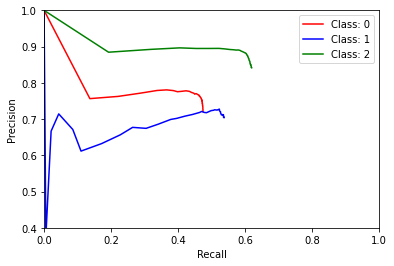

In [48]:
area = 0
for j in range(3):
  if len(match_values[j]) > 0:
    # maximum_score = score_values[j].max()
    maximum_score = max(score_values[j])
    ln= np.linspace(0.6,maximum_score,num=100)
    precision_mat= np.zeros(101)
    recall_mat= np.zeros(101)
    for i ,th in enumerate(ln):
      matches = np.array(match_values[j])[score_values[j] > th]
      TP = matches.sum()
      total_positive = matches.shape[0]
      precision = 1
      if total_positive > 0:
        precision = TP/total_positive
      recall =1
      if total_trues[j] > 0:
        recall = TP/total_trues[j]
      precision_mat[i] = precision
      recall_mat[i] = recall
    precision_mat[100] = 1
    recall_mat[100] = 0
    plt.figure(0)
    plt.ylim([0.4,1])
    plt.xlim([0,1])
    if j == 0:
      plt.plot(recall_mat,precision_mat, 'r-', label = ("Class: " + str(0) ))
    if j == 1:
      plt.plot(recall_mat,precision_mat, 'b-', label = ("Class: " + str(1) ))
    if j == 2:
      plt.plot(recall_mat,precision_mat, 'g-', label = ("Class: " + str(2) ))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    #plt.title("Class: "+ str(j))
    #plt.savefig("Class: " + str(j) + " curve")
    sorted_ind=np.argsort(recall_mat)
    sorted_recall=recall_mat[sorted_ind]
    sorted_precision=precision_mat[sorted_ind]
    
    area += auc(sorted_recall,sorted_precision)

plt.savefig("7.7 curve.png")
MAP = area/3

In [4]:
import pickle

In [253]:
with open('MAP_list for target 1.pickle','wb') as f:
  pickle.dump(MAP_list, f)

with open('AP_dict for target 1.pickle','wb') as f:
  pickle.dump(AP_dict, f)

In [14]:
with open('MAP_list for IOU.pickle', 'rb') as f:
    a = pickle.load(f)

with open('AP_dict for target 1.pickle', 'rb') as f:
    a = pickle.load(f)

print(a[0][-10])
print(a[1][-10])
print(a[2][-10])

0.3887391016308145
0.4382825362959103
0.5582166916505337
